# Static Plots

- [pandas.DataFrame.plot — pandas 1.4.1 documentation](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.plot.html)
- [Matplotlib — Visualization with Python](https://matplotlib.org/)
- [seaborn: statistical data visualization — seaborn 0.11.2 documentation](https://seaborn.pydata.org/)
- [Chart Visualization — pandas 1.4.2 documentation](https://pandas.pydata.org/docs/user_guide/visualization.html)



## 目次
- 約定データ取得
- df.plot() を使い倒す（倒したい）
- 探索的データ分析(EDA)


## 約定データ
- [crypto-chassis/cryptochassis-data-api-docs: A REST API providing snapshot, tick, and aggregated market data for crypto-currencies](https://github.com/crypto-chassis/cryptochassis-data-api-docs#trade)


In [27]:
import pandas as pd

In [65]:
df_btc_eur =pd.read_pickle("../data/binance_btc-eur.pkl")


In [66]:
df_btc_eur.head()

,time_seconds,price,size,is_buyer_maker,instrument
datetime,,,,,
2022-03-15 00:00:01.414000128+00:00,1.647302e+09,36300.77,0.00115,1,btc-eur
2022-03-15 00:00:01.472000+00:00,1.647302e+09,36303.01,0.00825,0,btc-eur
2022-03-15 00:00:03.670000128+00:00,1.647302e+09,36306.47,0.01195,0,btc-eur
2022-03-15 00:00:04.072000+00:00,1.647302e+09,36306.57,0.01912,0,btc-eur
2022-03-15 00:00:04.108999936+00:00,1.647302e+09,36306.57,0.00389,0,btc-eur


In [67]:
df_btc_eur.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 770101 entries, 2022-03-15 00:00:01.414000128+00:00 to 2022-03-22 23:59:47.063000064+00:00
Data columns (total 5 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   time_seconds    770101 non-null  float64
 1   price           770101 non-null  float64
 2   size            770101 non-null  float64
 3   is_buyer_maker  770101 non-null  int64  
 4   instrument      770101 non-null  object 
dtypes: float64(3), int64(1), object(1)
memory usage: 35.3+ MB


In [91]:
# 5分のOHLCVに変換
rule="5min"
df_ohlc_btc_eur = df_btc_eur["price"].resample(rule, label="right").ohlc()
df_ohlc_btc_eur["volume"] = df_btc_eur["size"].resample(rule, label="right").sum()


In [92]:
df_ohlc_btc_eur.head()

,open,high,low,close,volume
datetime,,,,,
2022-03-14 00:05:00+00:00,34705.92,34736.71,34681.75,34730.34,6.62146
2022-03-14 00:10:00+00:00,34732.31,34732.31,34628.84,34637.02,9.43070
2022-03-14 00:15:00+00:00,34648.05,34658.28,34512.04,34573.60,10.00064
2022-03-14 00:20:00+00:00,34573.59,34800.00,34569.75,34722.50,14.08364
2022-03-14 00:25:00+00:00,34723.95,34751.51,34687.19,34737.34,5.59076


## df.plot() のオプションを使い倒す

`plot()` にはたくさんのオプションがあります。matplotlib や seaborn などを使わなくても事足りることがありますのでぜひ覚えてください。


- 価格帯別出来高
- ボリュームの(棒)グラフを下につける
- 指標は代表的なやつを1つ紹介する(SMA, RSIなど)

### plot メソッド

`plot()` はデフォルトで折れ線グラフを描画します


<AxesSubplot:xlabel='datetime'>

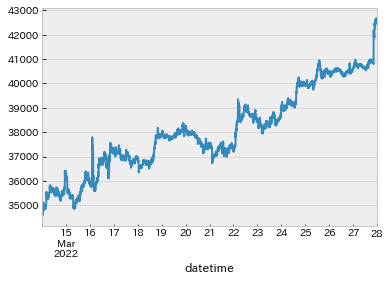

In [93]:
df_ohlc_btc_eur["close"].plot()

### plot オプション

罫線や描画サイズなど、オプションで変更できます。

<AxesSubplot:title={'center':'Close'}, xlabel='datetime'>

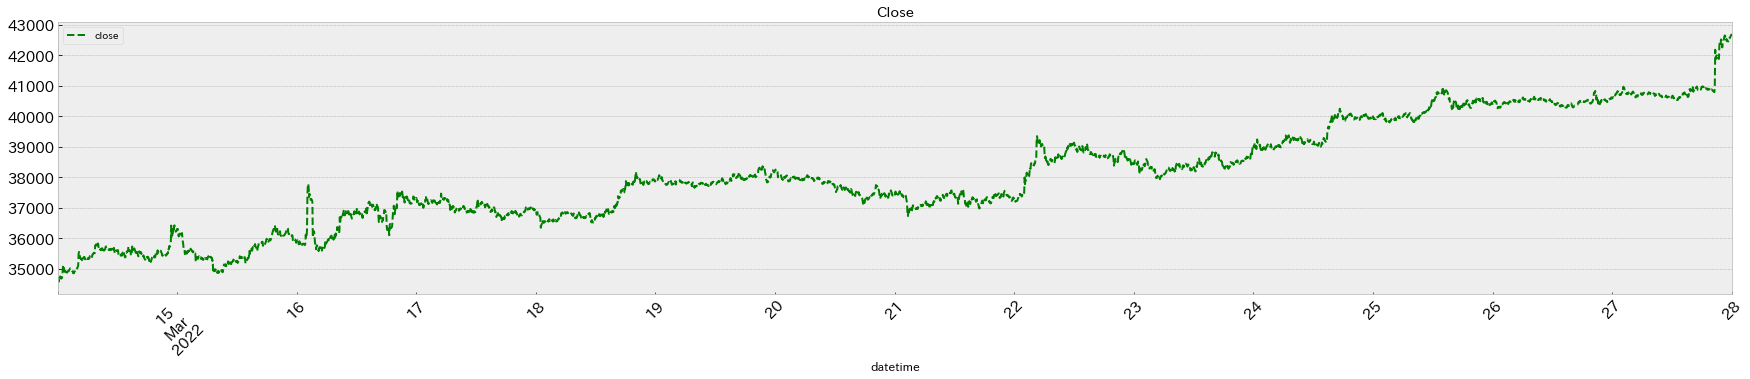

In [94]:
df_ohlc_btc_eur["close"].plot(
    grid=True, # 罫線
    figsize=(30,5),  # 描画サイズ（横、縦）
    title="Close",  # グラフタイトル
    legend=True,  # 凡例
    rot=45,  # xtick の ローテーション
    fontsize=15, # 文字サイズ
    style={"close": "g--"}, # 色と線の種類
    )

### サブプロット

同じ DataFrame にあるデータであれば、 `subplots=True,` オプションでサブプロットできます

In [95]:
import ta
df_ohlc_btc_eur["RSI14"] = ta.momentum.rsi(df_ohlc_btc_eur["close"], window=14)

In [96]:
df_ohlc_btc_eur.head()

,open,high,low,close,volume,RSI14
datetime,,,,,,
2022-03-14 00:05:00+00:00,34705.92,34736.71,34681.75,34730.34,6.62146,NaN
2022-03-14 00:10:00+00:00,34732.31,34732.31,34628.84,34637.02,9.43070,NaN
2022-03-14 00:15:00+00:00,34648.05,34658.28,34512.04,34573.60,10.00064,NaN
2022-03-14 00:20:00+00:00,34573.59,34800.00,34569.75,34722.50,14.08364,NaN
2022-03-14 00:25:00+00:00,34723.95,34751.51,34687.19,34737.34,5.59076,NaN


array([[<AxesSubplot:xlabel='datetime'>],
       [<AxesSubplot:xlabel='datetime'>]], dtype=object)

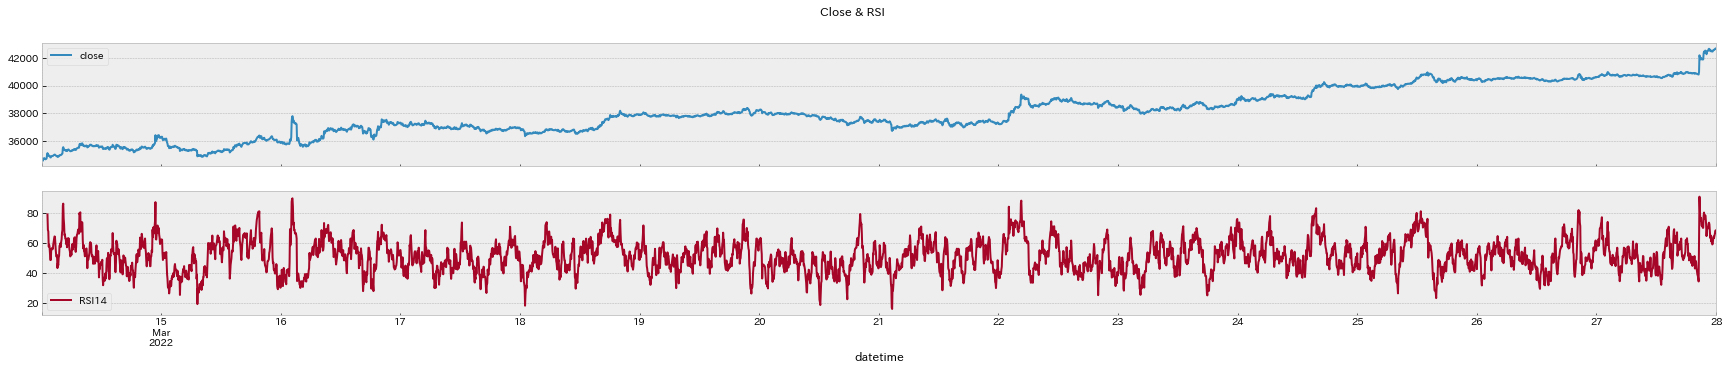

In [97]:
df_ohlc_btc_eur[["close", "RSI14"]].plot(
    grid=True, 
    figsize=(30,5), 
    title="Close & RSI", 
    legend=True, 
    subplots=True, 
    layout=(2,1), # レイアウト（行,欄）
   
    )

### 第二軸

`secondary_y=` オプションで、右側にｙの第二軸を取ることができます

<AxesSubplot:xlabel='datetime'>

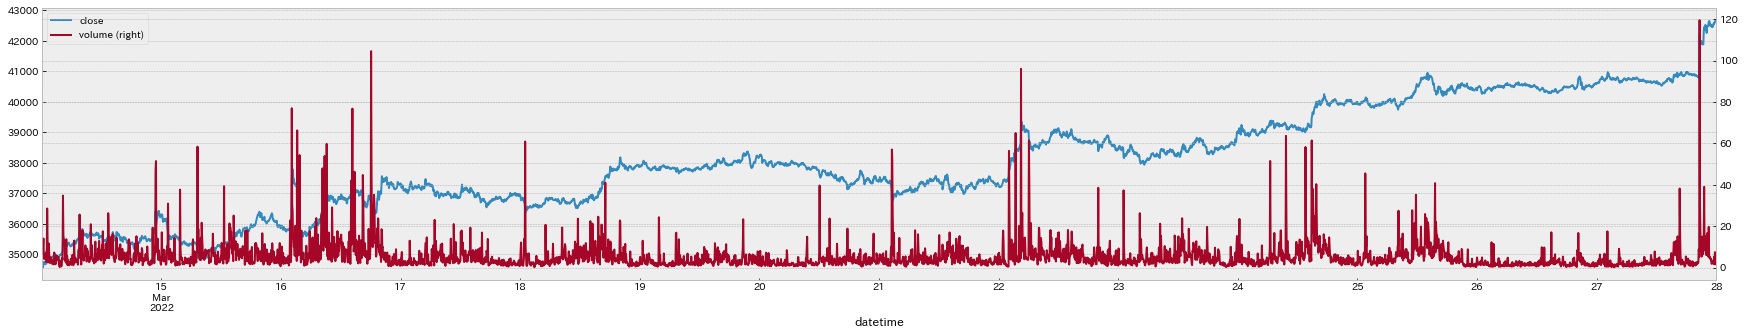

In [98]:
df_ohlc_btc_eur[["close", "volume"]].plot(
    grid=True,    
    figsize=(30,5),
    secondary_y="volume", 
    )

### bar について

TODO: 棒グラフがとても遅い。解決策をどりらんせんせいに聞く


<AxesSubplot:>

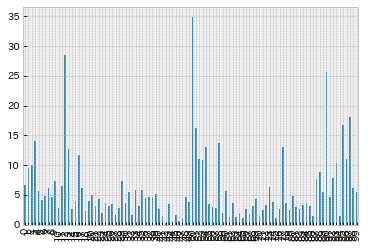

In [99]:
df_ohlc_btc_eur["volume"].head(100).plot(kind="bar", use_index = False )



### 日本語豆腐問題

<AxesSubplot:title={'center':'終値'}, xlabel='時間', ylabel='価格'>

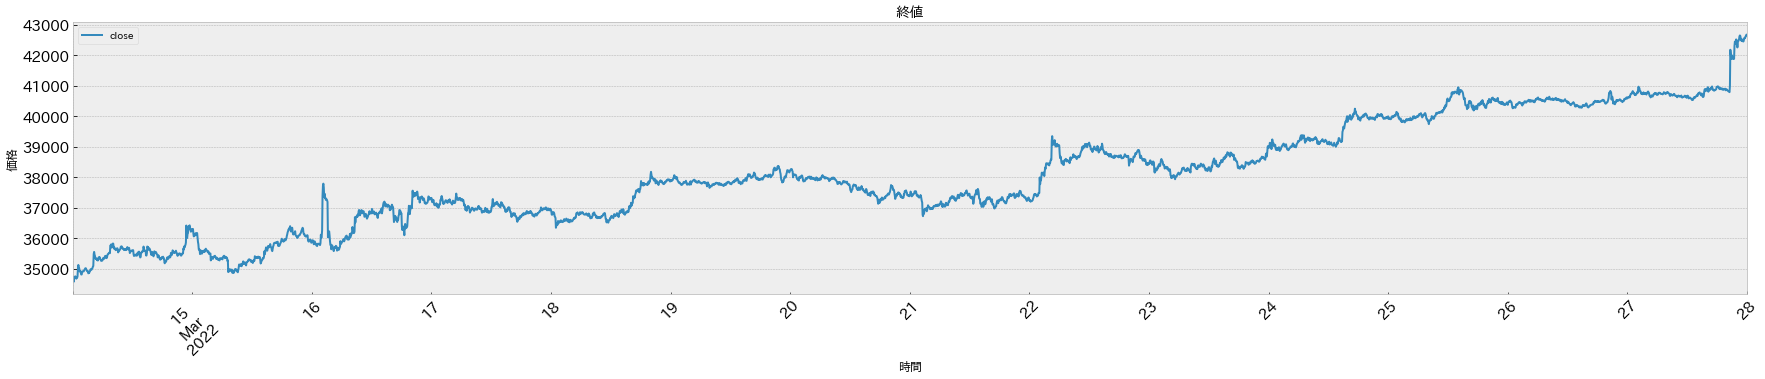

In [100]:
import japanize_matplotlib

df_ohlc_btc_eur["close"].plot(grid=True, figsize=(30,5), title="終値", legend=True, rot=45, fontsize=15, xlabel="時間", ylabel="価格")


## matplotlib も少し使う
- テストデータとして3月15日〜28日の14日分の約定データを用意している


In [101]:
df_ohlc_btc_eur["hour"] = df_ohlc_btc_eur.index.hour
df_ohlc_btc_eur["day_name"] = df_ohlc_btc_eur.index.day_name()
df_ohlc_btc_eur["price_change"] = df_ohlc_btc_eur["close"].pct_change()

<AxesSubplot:ylabel='Frequency'>

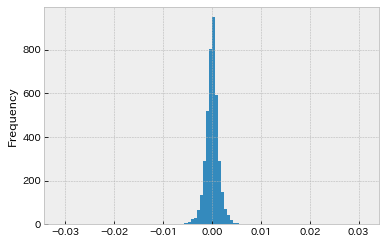

In [102]:
df_ohlc_btc_eur["price_change"].plot(kind="hist", bins=100, grid=True)

day_name
Friday       AxesSubplot(0.125,0.125;0.775x0.755)
Monday       AxesSubplot(0.125,0.125;0.775x0.755)
Saturday     AxesSubplot(0.125,0.125;0.775x0.755)
Sunday       AxesSubplot(0.125,0.125;0.775x0.755)
Thursday     AxesSubplot(0.125,0.125;0.775x0.755)
Tuesday      AxesSubplot(0.125,0.125;0.775x0.755)
Wednesday    AxesSubplot(0.125,0.125;0.775x0.755)
Name: price_change, dtype: object

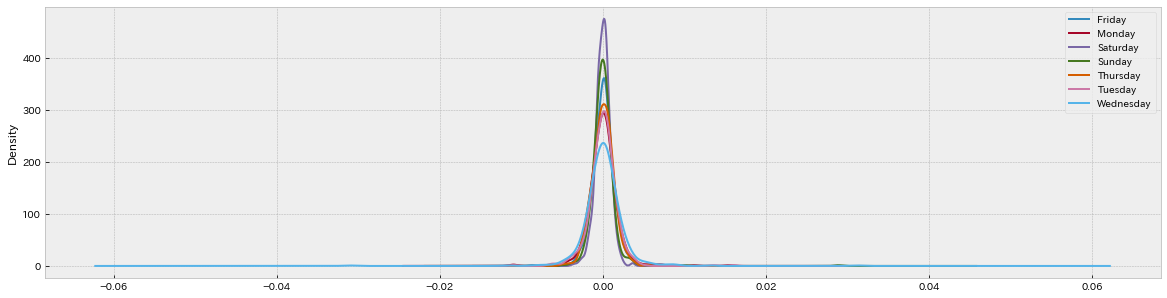

In [103]:
df_ohlc_btc_eur.groupby("day_name")["price_change"].plot(kind="kde",  grid=True, legend=True, figsize=(20,5))

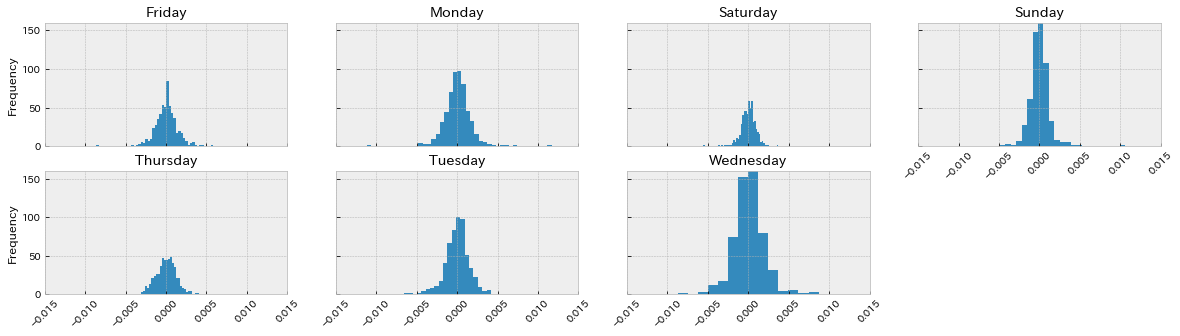

In [115]:
import matplotlib.pyplot as plt 
fig = plt.figure(figsize=(20,5))

i = 1
for name, s in list(df_ohlc_btc_eur.groupby("day_name")["price_change"]):
    ax = fig.add_subplot(2,4,i)
    s.plot(kind="hist", ax=ax, title=name, xlim=(-0.015, 0.015), ylim=(0, 160), sharex=True, sharey=True,  grid=True, bins=50, rot=45) # 
    i += 1
    

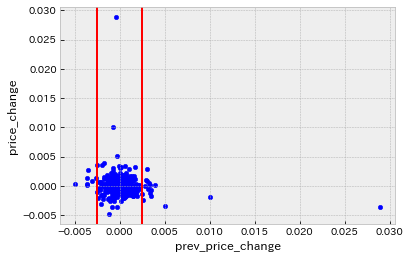

In [116]:
df_ohlc_btc_eur["prev_price_change"] = df_ohlc_btc_eur["price_change"].shift(2)
ax = df_ohlc_btc_eur[df_ohlc_btc_eur["day_name"] == "Sunday"].plot(kind="scatter", x = "prev_price_change", y="price_change", grid=True)
ax.axvline(-0.0025, c="red")
ax.axvline(0.0025, c="red")


## テーマ変更

matplotlibのstyleを変える - Qiita
https://qiita.com/eriksoon/items/b93030ba4dc686ecfbba

[Style sheets reference — Matplotlib 3.5.1 documentation](https://matplotlib.org/3.5.1/gallery/style_sheets/style_sheets_reference.html)




In [80]:
plt.style.use("bmh")

## 価格帯別出来高


In [117]:
df_15min = df_btc_eur["price"].resample("15min", label="right").ohlc()
df_15min["volume"] = df_btc_eur["size"].resample("15min", label="right").sum()
df_15min["pricecut"] = pd.cut(df_15min["close"], 30, ).apply(lambda x: x.left)
s_vol_by_price = df_15min.groupby("pricecut")["volume"].sum()

<AxesSubplot:ylabel='pricecut'>

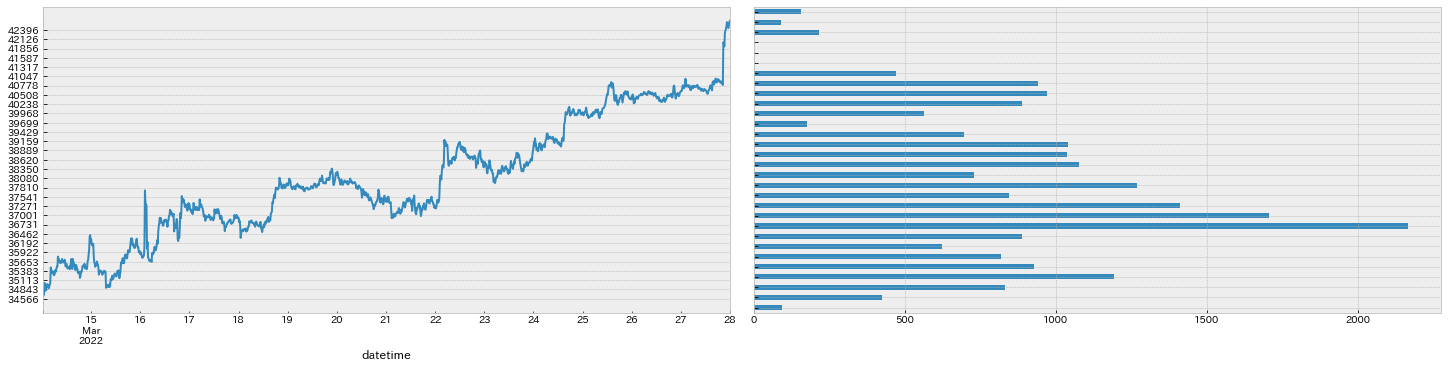

In [118]:
import matplotlib.pyplot as plt
fig, axes = plt.subplots(1, 2, figsize=(20, 5), constrained_layout = True)
df_15min["close"].plot(ax=axes[0], yticks=s_vol_by_price.index, grid=True)
s_vol_by_price.plot(kind="barh",ax=axes[1],sharey=axes[0], grid=True)


## 板情報

In [125]:
df_depth = pd.read_pickle("../data/binance_btc-eur_2022-03-14.pkl")

In [126]:
df_depth.head()

,price,size,timestamp,side
2022-03-14 00:00:00,34706.62,0.15000,2022-03-14 00:00:00,bid
2022-03-14 00:00:00,34706.63,0.02429,2022-03-14 00:00:00,ask
2022-03-14 00:00:01,34706.62,0.08059,2022-03-14 00:00:01,ask
2022-03-14 00:00:01,34706.43,0.15000,2022-03-14 00:00:01,bid
2022-03-14 00:00:02,34705.30,0.13233,2022-03-14 00:00:02,bid
